<a href="https://colab.research.google.com/github/codekikicode/python-coding-folio/blob/main/Fashion_MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework: FashionMNIST

For this homework assignment, you are asked to build a neural network classifier on the FasionMNIST dataset. The FashionMNIST dataset has a lot in common with the MNIST dataset:
- The dataset contains 70,000 grayscale images, split into training set (60,000 images) and test set (10,000 images).
- The resolution of images is 28 by 28 pixels.
- There are a total of 10 target labels.

<img src="https://tensorflow.org/images/fashion-mnist-sprite.png" width="600">

In [ ]:
# Starter Code
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Scale values to [0,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Load Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Label names
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.60MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 139kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.71MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.4MB/s]


Please complete the following tasks:
1. Use `plt.imshow()` to display the first two images from the training set.
2. Scale the values to [0, 1] using `transforms.Normalize((0.5,), (0.5,))`.
3. Build a neural network class with the following components:
    - A convolutional layer with 32 output channels (kernel size = 3, ReLU activation)
    - A convolutional layer with 64 output channels (kernel size = 3, ReLU activation)
    - A max-pooling layer that reduces each 2x2 block to a single value
    - A flatten layer
    - A dense layer with 128 nodes (ReLU activation)
    - A dense layer with 10 nodes (No activation needed)
4. Build the model object, loss function, and the optimizer.
5. Train the model using `train_dataset` for 10 epochs.
6. Display the accuracy on the test set.
7. Compute the confusion matrix over test set. Which type of prediction mistake occurs most frequently?

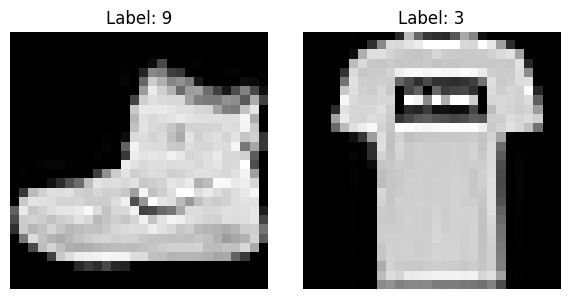

In [ ]:
# Display first two training images
fig, axes = plt.subplots(1, 2, figsize=(6,3))

for i in range(2):
    image, label = train_dataset[i]
    # Reduce channel dim (1, 28, 28) to (28, 28)
    image = image.squeeze()
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {labels[label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Build CNN model class
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # 28 * 28 to 14 * 14
        x = self.pool(F.relu(self.conv1(x)))
        # 14 * 14 to 7 * 7
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = FashionCNN().to(device)


In [ ]:
# Create an object model from the model class
model = FashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Set optimizer and loss function
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")


Epoch 1, Loss: 449.6949
Epoch 2, Loss: 290.8712
Epoch 3, Loss: 248.0944
Epoch 4, Loss: 220.4887
Epoch 5, Loss: 195.5041
Epoch 6, Loss: 177.0532
Epoch 7, Loss: 155.8504
Epoch 8, Loss: 142.4114
Epoch 9, Loss: 128.6466
Epoch 10, Loss: 116.3258


In [ ]:
# Display test accuracy
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 4.31%


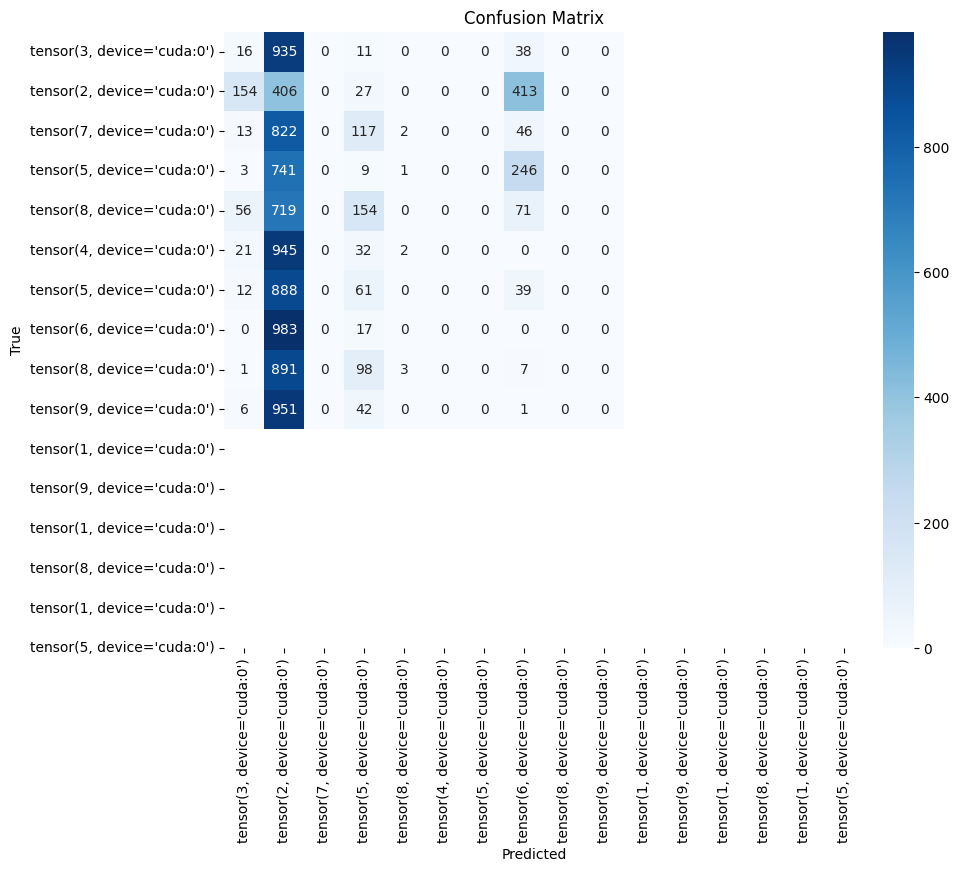

In [ ]:
# Compute Confusion Matrix on test set
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels_batch in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot it
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Mask diagonal (correct predictions) to find max off-diagonal error
import numpy as np

cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

max_error = np.unravel_index(np.argmax(cm_no_diag), cm_no_diag.shape)
true_label = labels[max_error[0]]
predicted_label = labels[max_error[1]]

print(f"The most frequent mistake is predicting '{predicted_label}' instead of '{true_label}' ({cm[max_error]} times).")


The most frequent mistake is predicting '2' instead of '6' (983 times).
